In [1]:
import scipy.io
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data_dict = {'Lung_Lesion': 0,
 'Atelectasis': 1,
 'No_Finding': 2,
 'Edema': 3,
 'Lung_Opacity': 4,
 'Cardiomegaly': 5,
 'Pleural_Other': 6,
 'Fracture': 7,
 'Pneumonia': 8,
 'Enlarged_Cardiomediastinum': 9,
 'Pleural_Effusion': 10,
 'Pneumothorax': 11,
 'Support_Devices': 12,
 'Consolidation': 13}

In [16]:
test_img = 'Data/No_Finding/frontal_0.jpg'

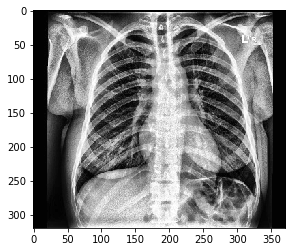

In [24]:
plt.imshow(_load_image(test_img), cmap= 'gray')

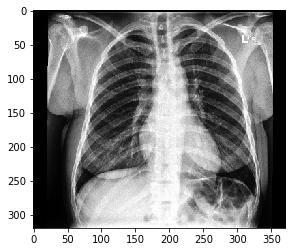

In [27]:
plt.imshow(plt.imread(test_img), cmap='gray')

In [38]:
def equalize(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(img)
    return cl

def _load_image(path):
    image = cv2.imread(path,0)
    if image is not None:
        image = equalize(image)
        image = cv2.resize(image, (299,299))
        return image
    return None




 42%|████▏     | 6929/16382 [00:54<00:41, 225.19it/s]

In [29]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [30]:
def _build_examples_list(input_folder, seed):
    examples = []
    for classname in os.listdir(input_folder):
        class_dir = os.path.join(input_folder, classname)
        if (os.path.isdir(class_dir)):
            for filename in os.listdir(class_dir):
                filepath = os.path.join(class_dir, filename)
                example = {
                    'classname': classname, 
                    'path': filepath,
                    'label': data_dict[classname]
                }
                examples.append(example)

    random.seed(seed)
    random.shuffle(examples)
    return examples

In [31]:
def _split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

In [32]:
def _get_examples_share(examples, training_split):
    examples_size = len(examples)
    len_training_examples = int(examples_size * training_split)

    return np.split(examples, [len_training_examples])

In [33]:
def _write_tfrecord(examples, output_filename):
    writer = tf.io.TFRecordWriter(output_filename)
    for example in tqdm(examples):
        try:
            image = _load_image(example['path'])
            if image is not None:
                encoded_image_string = cv2.imencode('.jpg', image)[1].tostring()
                feature = {
                    'label': _bytes_feature(tf.compat.as_bytes(str(example['label']))),
                    'image': _bytes_feature(tf.compat.as_bytes(encoded_image_string)),
                    'classname': _bytes_feature(tf.compat.as_bytes(example['classname']))
                }

                tf_example = tf.train.Example(features = tf.train.Features(feature=feature))
                writer.write(tf_example.SerializeToString())
        except Exception as inst:
            print(inst)
            pass
    writer.close()

In [34]:
def _write_sharded_tfrecord(examples, number_of_shards, base_output_filename, is_training = True):
    sharded_examples = _split_list(examples, number_of_shards)
    for count, shard in tqdm(enumerate(sharded_examples, start = 1)):
        output_filename = '{0}_{1}_{2:02d}of{3:02d}.tfrecord'.format(
            base_output_filename,
            'train' if is_training else 'test',
            count,
            number_of_shards 
        )
        _write_tfrecord(shard, output_filename)

In [35]:
#list of dictionaries {classname:'' , path:''}
train_list = _build_examples_list(r'/home/scott/CSE6250/Data', 123)

In [36]:
training_examples, _ = _get_examples_share(train_list,1.0)

In [39]:
print("Creating training shards", flush = True)
_write_sharded_tfrecord(training_examples, number_of_shards=2, base_output_filename='/home/scott/CSE6250/tfrecords/')

Creating training shards






0it [00:00, ?it/s]




  0%|          | 0/16382 [00:00<?, ?it/s]




  0%|          | 23/16382 [00:00<01:14, 220.42it/s]




  0%|          | 51/16382 [00:00<01:09, 234.60it/s]




  0%|          | 77/16382 [00:00<01:07, 239.95it/s]




  1%|          | 105/16382 [00:00<01:04, 250.62it/s]




  1%|          | 126/16382 [00:00<01:10, 229.82it/s]




  1%|          | 151/16382 [00:00<01:09, 234.94it/s]




  1%|          | 173/16382 [00:00<01:12, 223.34it/s]




  1%|          | 203/16382 [00:00<01:06, 241.51it/s]




  1%|▏         | 227/16382 [00:00<01:07, 239.25it/s]




  2%|▏         | 251/16382 [00:01<01:08, 234.98it/s]




  2%|▏         | 275/16382 [00:01<01:10, 229.95it/s]




  2%|▏         | 307/16382 [00:01<01:04, 250.11it/s]




  2%|▏         | 333/16382 [00:01<01:06, 242.67it/s]




  2%|▏         | 363/16382 [00:01<01:02, 256.62it/s]




  2%|▏         | 390/16382 [00:01<01:02, 257.91it/s]




  3%|▎         | 419/16382 [00:01<01:00, 265.16it/s]




  3%|▎         | 4

 20%|█▉        | 3256/16382 [00:11<00:49, 267.51it/s]




 20%|██        | 3290/16382 [00:11<00:45, 285.28it/s]




 20%|██        | 3321/16382 [00:11<00:44, 290.65it/s]




 20%|██        | 3351/16382 [00:12<00:45, 288.07it/s]




 21%|██        | 3381/16382 [00:12<00:44, 291.44it/s]




 21%|██        | 3412/16382 [00:12<00:43, 295.55it/s]




 21%|██        | 3444/16382 [00:12<00:43, 300.60it/s]




 21%|██        | 3475/16382 [00:12<00:44, 293.30it/s]




 21%|██▏       | 3505/16382 [00:12<00:43, 293.85it/s]




 22%|██▏       | 3536/16382 [00:12<00:43, 298.03it/s]




 22%|██▏       | 3566/16382 [00:12<00:43, 291.68it/s]




 22%|██▏       | 3599/16382 [00:12<00:42, 300.80it/s]




 22%|██▏       | 3630/16382 [00:12<00:43, 292.37it/s]




 22%|██▏       | 3662/16382 [00:13<00:42, 299.10it/s]




 23%|██▎       | 3693/16382 [00:13<00:42, 295.93it/s]




 23%|██▎       | 3723/16382 [00:13<00:43, 290.92it/s]




 23%|██▎       | 3755/16382 [00:13<00:42, 297.17it/s]




 23%|██▎      

 41%|████▏     | 6758/16382 [00:23<00:31, 304.40it/s]




 41%|████▏     | 6789/16382 [00:23<00:32, 292.41it/s]




 42%|████▏     | 6819/16382 [00:23<00:39, 243.56it/s]




 42%|████▏     | 6845/16382 [00:23<00:42, 224.17it/s]




 42%|████▏     | 6877/16382 [00:23<00:38, 246.18it/s]




 42%|████▏     | 6909/16382 [00:23<00:36, 263.13it/s]




 42%|████▏     | 6943/16382 [00:24<00:33, 282.20it/s]




 43%|████▎     | 6973/16382 [00:24<00:33, 278.21it/s]




 43%|████▎     | 7002/16382 [00:24<00:34, 269.80it/s]




 43%|████▎     | 7030/16382 [00:24<00:35, 261.94it/s]




 43%|████▎     | 7057/16382 [00:24<00:37, 248.64it/s]




 43%|████▎     | 7083/16382 [00:24<00:38, 239.20it/s]




 43%|████▎     | 7108/16382 [00:24<00:39, 236.53it/s]




 44%|████▎     | 7132/16382 [00:24<00:42, 219.81it/s]




 44%|████▎     | 7160/16382 [00:25<00:39, 233.82it/s]




 44%|████▍     | 7184/16382 [00:25<00:39, 235.00it/s]




 44%|████▍     | 7215/16382 [00:25<00:36, 253.25it/s]




 44%|████▍    

 61%|██████    | 9961/16382 [00:35<00:24, 260.21it/s]




 61%|██████    | 9991/16382 [00:35<00:23, 269.28it/s]




 61%|██████    | 10023/16382 [00:36<00:22, 281.72it/s]




 61%|██████▏   | 10052/16382 [00:36<00:22, 281.81it/s]




 62%|██████▏   | 10081/16382 [00:36<00:22, 282.70it/s]




 62%|██████▏   | 10110/16382 [00:36<00:22, 277.81it/s]




 62%|██████▏   | 10139/16382 [00:36<00:23, 266.78it/s]




 62%|██████▏   | 10166/16382 [00:36<00:24, 249.22it/s]




 62%|██████▏   | 10195/16382 [00:36<00:23, 259.51it/s]




 62%|██████▏   | 10228/16382 [00:36<00:22, 276.17it/s]




 63%|██████▎   | 10257/16382 [00:36<00:21, 279.47it/s]




 63%|██████▎   | 10286/16382 [00:37<00:22, 272.89it/s]




 63%|██████▎   | 10315/16382 [00:37<00:21, 276.60it/s]




 63%|██████▎   | 10345/16382 [00:37<00:21, 282.03it/s]




 63%|██████▎   | 10378/16382 [00:37<00:20, 294.66it/s]




 64%|██████▎   | 10408/16382 [00:37<00:20, 295.88it/s]




 64%|██████▎   | 10438/16382 [00:37<00:21, 282.38it/s]





 79%|███████▉  | 12993/16382 [00:47<00:14, 241.84it/s]




 79%|███████▉  | 13018/16382 [00:48<00:14, 236.95it/s]




 80%|███████▉  | 13044/16382 [00:48<00:13, 242.31it/s]




 80%|███████▉  | 13071/16382 [00:48<00:13, 249.47it/s]




 80%|███████▉  | 13097/16382 [00:48<00:13, 250.11it/s]




 80%|████████  | 13128/16382 [00:48<00:12, 263.53it/s]




 80%|████████  | 13155/16382 [00:48<00:12, 260.48it/s]




 80%|████████  | 13186/16382 [00:48<00:11, 273.30it/s]




 81%|████████  | 13216/16382 [00:48<00:11, 279.68it/s]




 81%|████████  | 13247/16382 [00:48<00:10, 286.81it/s]




 81%|████████  | 13276/16382 [00:49<00:11, 274.28it/s]




 81%|████████  | 13304/16382 [00:49<00:11, 274.30it/s]




 81%|████████▏ | 13333/16382 [00:49<00:10, 277.37it/s]




 82%|████████▏ | 13362/16382 [00:49<00:10, 280.46it/s]




 82%|████████▏ | 13393/16382 [00:49<00:10, 287.12it/s]




 82%|████████▏ | 13422/16382 [00:49<00:10, 278.93it/s]




 82%|████████▏ | 13451/16382 [00:49<00:10, 273.76it/s]



 99%|█████████▊| 16151/16382 [00:59<00:01, 219.07it/s]




 99%|█████████▊| 16175/16382 [00:59<00:00, 224.38it/s]




 99%|█████████▉| 16203/16382 [00:59<00:00, 237.26it/s]




 99%|█████████▉| 16232/16382 [00:59<00:00, 249.53it/s]




 99%|█████████▉| 16258/16382 [01:00<00:00, 251.07it/s]




 99%|█████████▉| 16290/16382 [01:00<00:00, 268.02it/s]




100%|█████████▉| 16318/16382 [01:00<00:00, 265.17it/s]




100%|█████████▉| 16345/16382 [01:00<00:00, 259.75it/s]




100%|██████████| 16382/16382 [01:00<00:00, 270.78it/s]




1it [01:01, 61.92s/it]




  0%|          | 0/16382 [00:00<?, ?it/s]




  0%|          | 27/16382 [00:00<01:01, 265.23it/s]




  0%|          | 56/16382 [00:00<01:00, 269.28it/s]




  1%|          | 83/16382 [00:00<01:00, 268.56it/s]




  1%|          | 101/16382 [00:00<01:11, 227.36it/s]




  1%|          | 129/16382 [00:00<01:07, 239.50it/s]




  1%|          | 155/16382 [00:00<01:06, 244.02it/s]




  1%|          | 185/16382 [00:00<01:02, 257.39it/s]






 17%|█▋        | 2731/16382 [00:10<00:52, 260.74it/s]




 17%|█▋        | 2760/16382 [00:11<00:50, 267.81it/s]




 17%|█▋        | 2787/16382 [00:11<00:52, 260.60it/s]




 17%|█▋        | 2814/16382 [00:11<00:52, 259.74it/s]




 17%|█▋        | 2843/16382 [00:11<00:50, 267.12it/s]




 18%|█▊        | 2870/16382 [00:11<00:53, 254.28it/s]




 18%|█▊        | 2896/16382 [00:11<00:52, 255.73it/s]




 18%|█▊        | 2922/16382 [00:11<00:53, 250.64it/s]




 18%|█▊        | 2948/16382 [00:11<00:55, 242.77it/s]




 18%|█▊        | 2973/16382 [00:11<01:02, 213.64it/s]




 18%|█▊        | 2996/16382 [00:12<01:11, 187.22it/s]




 18%|█▊        | 3016/16382 [00:12<01:10, 190.70it/s]




 19%|█▊        | 3036/16382 [00:12<01:11, 187.95it/s]




 19%|█▊        | 3056/16382 [00:12<01:10, 189.18it/s]




 19%|█▉        | 3078/16382 [00:12<01:07, 196.41it/s]




 19%|█▉        | 3102/16382 [00:12<01:04, 206.45it/s]




 19%|█▉        | 3126/16382 [00:12<01:01, 215.00it/s]




 19%|█▉       

 35%|███▍      | 5691/16382 [00:23<00:48, 222.53it/s]




 35%|███▍      | 5719/16382 [00:23<00:45, 235.29it/s]




 35%|███▌      | 5752/16382 [00:23<00:41, 257.21it/s]




 35%|███▌      | 5780/16382 [00:23<00:40, 261.74it/s]




 35%|███▌      | 5808/16382 [00:23<00:40, 259.13it/s]




 36%|███▌      | 5836/16382 [00:23<00:39, 264.47it/s]




 36%|███▌      | 5864/16382 [00:23<00:39, 264.88it/s]




 36%|███▌      | 5892/16382 [00:24<00:39, 268.64it/s]




 36%|███▌      | 5920/16382 [00:24<00:38, 268.42it/s]




 36%|███▋      | 5948/16382 [00:24<00:38, 267.62it/s]




 36%|███▋      | 5978/16382 [00:24<00:37, 274.55it/s]




 37%|███▋      | 6008/16382 [00:24<00:37, 279.85it/s]




 37%|███▋      | 6037/16382 [00:24<00:37, 278.00it/s]




 37%|███▋      | 6070/16382 [00:24<00:35, 291.19it/s]




 37%|███▋      | 6100/16382 [00:24<00:35, 285.82it/s]




 37%|███▋      | 6129/16382 [00:24<00:42, 240.13it/s]




 38%|███▊      | 6155/16382 [00:25<00:47, 214.62it/s]




 38%|███▊     

 53%|█████▎    | 8671/16382 [00:35<00:34, 224.58it/s]




 53%|█████▎    | 8694/16382 [00:35<00:34, 224.54it/s]




 53%|█████▎    | 8717/16382 [00:35<00:35, 214.45it/s]




 53%|█████▎    | 8739/16382 [00:35<00:38, 199.04it/s]




 53%|█████▎    | 8760/16382 [00:36<00:42, 178.73it/s]




 54%|█████▎    | 8781/16382 [00:36<00:40, 186.01it/s]




 54%|█████▎    | 8804/16382 [00:36<00:38, 195.64it/s]




 54%|█████▍    | 8825/16382 [00:36<00:39, 191.40it/s]




 54%|█████▍    | 8845/16382 [00:36<00:43, 174.86it/s]




 54%|█████▍    | 8867/16382 [00:36<00:40, 184.24it/s]




 54%|█████▍    | 8886/16382 [00:36<00:44, 169.73it/s]




 54%|█████▍    | 8909/16382 [00:36<00:40, 183.02it/s]




 55%|█████▍    | 8936/16382 [00:36<00:36, 201.75it/s]




 55%|█████▍    | 8964/16382 [00:37<00:33, 218.32it/s]




 55%|█████▍    | 8991/16382 [00:37<00:32, 230.14it/s]




 55%|█████▌    | 9015/16382 [00:37<00:33, 218.70it/s]




 55%|█████▌    | 9038/16382 [00:37<00:36, 200.52it/s]




 55%|█████▌   

 67%|██████▋   | 10971/16382 [00:47<00:32, 167.31it/s]




 67%|██████▋   | 10989/16382 [00:48<00:31, 169.17it/s]




 67%|██████▋   | 11007/16382 [00:48<00:31, 169.23it/s]




 67%|██████▋   | 11025/16382 [00:48<00:31, 171.04it/s]




 67%|██████▋   | 11043/16382 [00:48<00:31, 171.33it/s]




 68%|██████▊   | 11061/16382 [00:48<00:34, 154.94it/s]




 68%|██████▊   | 11077/16382 [00:48<00:36, 144.12it/s]




 68%|██████▊   | 11092/16382 [00:48<00:42, 125.75it/s]




 68%|██████▊   | 11106/16382 [00:48<00:41, 126.18it/s]




 68%|██████▊   | 11120/16382 [00:49<00:40, 129.29it/s]




 68%|██████▊   | 11134/16382 [00:49<00:40, 128.85it/s]




 68%|██████▊   | 11148/16382 [00:49<00:42, 122.30it/s]




 68%|██████▊   | 11161/16382 [00:49<00:44, 116.78it/s]




 68%|██████▊   | 11174/16382 [00:49<00:43, 119.46it/s]




 68%|██████▊   | 11187/16382 [00:49<00:42, 121.84it/s]




 68%|██████▊   | 11200/16382 [00:49<00:41, 124.01it/s]




 68%|██████▊   | 11213/16382 [00:49<00:44, 116.41it/s]



 82%|████████▏ | 13364/16382 [01:00<00:11, 252.13it/s]




 82%|████████▏ | 13393/16382 [01:00<00:11, 262.22it/s]




 82%|████████▏ | 13420/16382 [01:00<00:11, 263.17it/s]




 82%|████████▏ | 13447/16382 [01:00<00:11, 257.91it/s]




 82%|████████▏ | 13473/16382 [01:00<00:12, 239.42it/s]




 82%|████████▏ | 13498/16382 [01:00<00:11, 242.02it/s]




 83%|████████▎ | 13523/16382 [01:00<00:11, 243.48it/s]




 83%|████████▎ | 13548/16382 [01:00<00:11, 243.81it/s]




 83%|████████▎ | 13573/16382 [01:00<00:11, 240.88it/s]




 83%|████████▎ | 13599/16382 [01:01<00:11, 243.59it/s]




 83%|████████▎ | 13624/16382 [01:01<00:11, 242.91it/s]




 83%|████████▎ | 13649/16382 [01:01<00:11, 243.37it/s]




 83%|████████▎ | 13676/16382 [01:01<00:10, 250.55it/s]




 84%|████████▎ | 13702/16382 [01:01<00:11, 239.23it/s]




 84%|████████▍ | 13727/16382 [01:01<00:11, 238.59it/s]




 84%|████████▍ | 13753/16382 [01:01<00:10, 243.42it/s]




 84%|████████▍ | 13778/16382 [01:01<00:10, 241.77it/s]



 96%|█████████▌| 15753/16382 [01:12<00:04, 153.32it/s]




 96%|█████████▋| 15769/16382 [01:13<00:04, 150.82it/s]




 96%|█████████▋| 15785/16382 [01:13<00:04, 147.65it/s]




 96%|█████████▋| 15802/16382 [01:13<00:03, 152.13it/s]




 97%|█████████▋| 15818/16382 [01:13<00:03, 153.54it/s]




 97%|█████████▋| 15836/16382 [01:13<00:03, 158.59it/s]




 97%|█████████▋| 15852/16382 [01:13<00:03, 133.50it/s]




 97%|█████████▋| 15867/16382 [01:13<00:03, 135.41it/s]




 97%|█████████▋| 15890/16382 [01:13<00:03, 153.42it/s]




 97%|█████████▋| 15911/16382 [01:13<00:02, 166.40it/s]




 97%|█████████▋| 15929/16382 [01:14<00:02, 168.60it/s]




 97%|█████████▋| 15947/16382 [01:14<00:02, 164.69it/s]




 97%|█████████▋| 15965/16382 [01:14<00:02, 166.82it/s]




 98%|█████████▊| 15988/16382 [01:14<00:02, 180.28it/s]




 98%|█████████▊| 16010/16382 [01:14<00:01, 189.37it/s]




 98%|█████████▊| 16034/16382 [01:14<00:01, 200.42it/s]




 98%|█████████▊| 16055/16382 [01:14<00:01, 194.68it/s]



In [9]:
import glob
len(glob.glob('./Data/*/*'))

32764

In [11]:
200000/16382

12.208521548040533

# Data Input Pipeline

In [53]:
def resize_(img, lab):
    img = tf.image.resize(img, [299,299])
    return img, lab

def parse_fn(example):

    example_fmt = {
    'image': tf.io.FixedLenFeature((), tf.string, ""),
    'label': tf.io.FixedLenFeature((), tf.string, ""),
    'classname': tf.io.FixedLenFeature((), tf.string, "")
  }
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_jpeg(parsed["image"])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [299,299])

    idx = int(parsed['label'])
    depth = 13
    label = tf.one_hot(idx, depth)
    return image, label, parsed["classname"]

def make_dataset():
    files = tf.data.Dataset.list_files("/home/scott/CSE6250/tfrecords/*.tfrecord")
    dataset = files.interleave(
    tf.data.TFRecordDataset, cycle_length=1,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(map_func=parse_fn)
    dataset = dataset.batch(batch_size=10)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Model

In [54]:
from AutoEncoder.CheXpert import XrayAE_Functional

In [55]:
model = XrayAE_Functional()

In [56]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 32)      1536      
_________________________________________________________________
sequential_1 (Sequential)    (None, 75, 75, 32)        16384     
_________________________________________________________________
sequential_2 (Sequential)    (None, 38, 38, 32)        16384     
_________________________________________________________________
sequential_3 (Sequential)    (None, 19, 19, 16)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 5776)              0         
_________________________________________________________________
dense (Dense)                (None, 1200)              693240

In [57]:
data = make_dataset()

In [60]:
for img, lab, classname in data.take(1):
    img = img
    lab = lab
    classname = classname

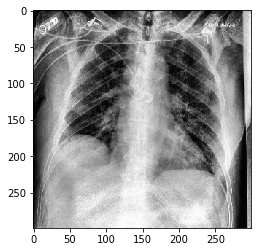

In [61]:
plt.imshow(np.squeeze(img[0]),cmap='gray')

In [23]:
output = model(img, training=True)

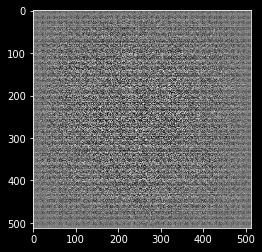

In [20]:
plt.figure()
plt.imshow(np.squeeze(output[0]), cmap='gray')
plt.show()

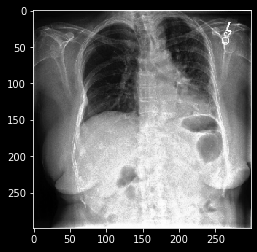

In [16]:
plt.figure()
plt.imshow(np.squeeze(img[0]), cmap='gray')
plt.show()

In [63]:
os.path.join("/home/easdf/keaf/", "*.tfrecord")

'/home/easdf/keaf/*.tfrecord'